In [1]:
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import CuDNNLSTM
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import pickle

C:\Users\ndrs\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
from matplotlib import pyplot
def loss_plot(history):
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show();
    
def acc_plot(history):
    pyplot.plot(history.history['acc'], label='train_acc')
    pyplot.plot(history.history['val_acc'], label='test_acc')
    pyplot.legend()
    pyplot.show();
    
def val_plot(y_true,y_pred,date):
    pyplot.plot(date,y_pred, label='predict')
    pyplot.plot(date,y_true, label='true')
    pyplot.legend()
    pyplot.show()    

def range_val_plot(y_true,y_pred,date,ini_range,end_range):
    pyplot.plot(date[ini_range:end_range],y_pred[ini_range:end_range], label='predict')
    pyplot.plot(date[ini_range:end_range],y_true[ini_range:end_range], label='true')
    pyplot.legend()
    pyplot.show()

In [3]:
def getSeatData(data,seatname):
    trial_data=data.loc[data['seatName']==seatname]
    trial_data=trial_data.sort_values(['Datetime'])
    #trial_data=trial_data.drop(['Country','Location','Resource Type','floor','Department','seatName','Datetime'],axis=1)
    trial_data=trial_data.drop(['Country','Location','Resource Type','floor','Department','seatName'],axis=1)
    trial_data.set_index('Datetime',inplace=True)
    return trial_data

def split_data(data,date):
    train_data,test_data=data.loc[data.index<date], data.loc[data.index>=date]
    print(len(train_data),len(test_data))
    return train_data,test_data

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [4]:
def model_arch(X_train):
    model = Sequential()
    model.add(CuDNNLSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

In [5]:
def rmse_score(y_true,y_pred):
    from sklearn.metrics import mean_squared_error
    from math import sqrt
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    print('Test RMSE: %.3f' % rmse)

In [10]:
def build_predictions(seat_data,date):
    look_back = 1
    train_data,test_data=split_data(seat_data,date)
    
    X_train, y_train = create_dataset(train_data.values, look_back)
    X_test, y_test = create_dataset(test_data.values, look_back)
    print(X_train.shape,X_test.shape)
    
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    #add values for arch
    model=model_arch(X_train)
    history = model.fit(X_train, y_train, epochs=300, batch_size=100,verbose=0, validation_data=(X_test, y_test), shuffle=False)
    loss_plot(history)
    acc_plot(history)
    
    dates = seat_data.tail(len(X_test)).index
    y_pred=model.predict(X_test)
    rmse_score(y_test,y_pred)
    val_plot(y_test,y_pred,dates)
    range_val_plot(y_test,y_pred,dates,300,400)
    return y_pred

In [11]:
complete_data=pickle.load(open('processed_data.p', "rb" ))

3456 1008
3455
1007
(3455, 1) (1007, 1)


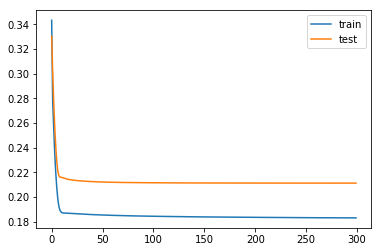

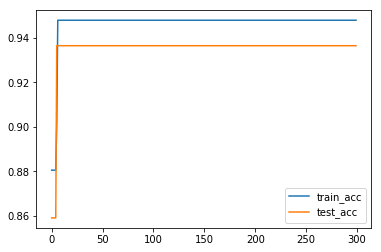

Test RMSE: 0.235


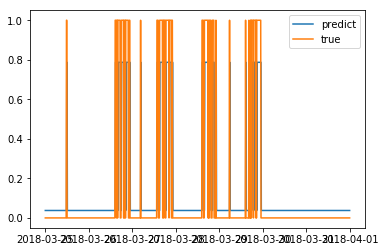

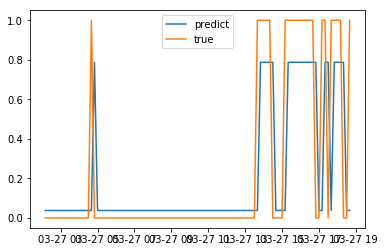

array([[0.03760678],
       [0.03760678],
       [0.03760678],
       ...,
       [0.03760678],
       [0.03760678],
       [0.03760678]], dtype=float32)

In [12]:
seat_data=getSeatData(complete_data,'B5_9_1_05')
build_predictions(seat_data,'2018-03-25')